# Data: analyising 12.5 year NANOGrav data incorporating integrated low-frequency constraints on the GW background

# Models: combinations of a Phase Transitions (PT) model, a simple power-law (PL), and astrophysically motivated binary black hole (BBH) model

## Christopher J. Moore, June 2021

This notebook describes the analyses in https://arxiv.org/abs/2104.15130.

### Load some standard libraries

In [6]:
import numpy as np
import pandas as pd

import os
import h5py

from scipy.stats import gaussian_kde as kde
from scipy.stats import loguniform, uniform

import dynesty
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal

import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request 
data_dir = './data/'


### Physical constants

In [7]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

''' Hubble constant in km/s/Mpc '''
H_0 = cosmo.H(0).value

''' parsec converted in cm '''
PC = 1.0 * u.parsec
PC_IN_CM = PC.to(u.cm).value

''' H0 = 100 km/s/Mpc converted is 1/sec '''
H_100_IN_ONE_OVER_SEC = 100. * 1.e5 / (1.e6 * PC_IN_CM)

''' H_0 converted is 1/sec '''
H_0_IN_ONE_OVER_SEC = H_0 * 1.e5 / (1.e6 * PC_IN_CM)

''' one year in sec '''
year = 3.154e+7

''' a frequency of 1/year in Hz '''
fyear = 1./year


### PT model spectra

In [8]:
# this is the NANOGrav model
from spectrum_calculator import h2_omega_sum


### Matplotlib Fonts

In [9]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Download NANOGrav data 

Download the public NANOGrav data files associated with the free spectrum analysis of the 12.5 year analysis from https://data.nanograv.org.

There are two important files:
 - "frequencies.txt" contains the locations of the different frequency bins (i.e. the x-axis values of the the left panel of Fig 1 in [1])
 - "12p5yr_DE438_model2a_PSDspectrum_chain.hdf5" contains the posterior samples (i.e. the samples used to make violin plots in that figure)

In [10]:
# Get NANOGrav frequencies
url_freqs = "https://data.nanograv.org/static/data/12p5yr_chains/frequencies.txt"
fname_freqs = data_dir+'frequencies.txt'

if not os.path.isfile(fname_freqs):
    urllib.request.urlretrieve(url_freqs, fname_freqs)
     
NANOGrav_frequencies = np.loadtxt(fname_freqs)


# Get NANOGrav posterior samples
url_samples = "https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_PSDspectrum_chain.hdf5"
fname_samples = data_dir+'12p5yr_DE438_model2a_PSDspectrum_chain.hdf5'

if not os.path.isfile(fname_samples):
    urllib.request.urlretrieve(url_samples, fname_samples)

h5file = h5py.File(fname_samples, 'r')


We will use only GW ampltiude in the the first 5 frequency bins for our reanalysis; these are conained in cols [90:95]. 

In [11]:
Nfreqs = 5


### NANOGrav posteriors on the delay, $d(f)$

The h5 file contains the posterior samples on the delay, $d(f)$.

It might also be convenient to downsample the public data to a more managable number of points.

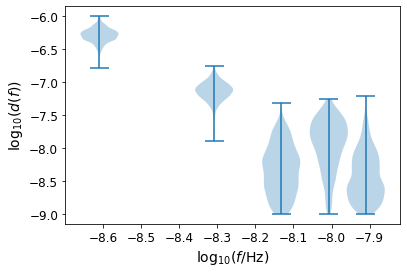

In [12]:
log10_delay_samples = np.array(h5file['samples'])

Nsamples = len(log10_delay_samples[:, 0])
Nsamples_to_use = 1000

downsample = np.random.choice(np.arange(Nsamples), Nsamples_to_use, replace=False)
log10_delay_samples = log10_delay_samples[downsample,90:90+Nfreqs]

plt.violinplot(log10_delay_samples, 
               positions=np.log10(NANOGrav_frequencies[:Nfreqs]),
               widths=0.1)
plt.xlabel(r'$\log_{10}$($f$/Hz)');plt.ylabel(r'$\log_{10}$($d(f)$)')
plt.show()


### The power spectrum, $S(f)$

The delay is related to the more commonly used power spectrum S(f) via

$$ d(f) = \sqrt{S(f)/T} $$

where $T=12.5$ years; see caption of Fig. 1 in [1].

We can use this to convert these samples to samples on $S(f)$.

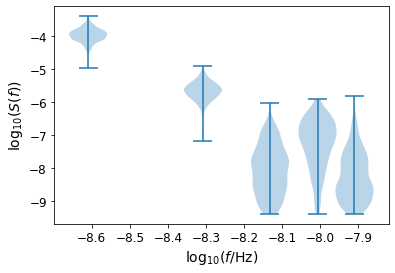

In [13]:
log10_S_samples = 2*log10_delay_samples - np.log10(NANOGrav_frequencies[0])

plt.violinplot(log10_S_samples, 
               positions=np.log10(NANOGrav_frequencies[:Nfreqs]),
               widths=0.1)
plt.xlabel(r'$\log_{10}$($f$/Hz)');plt.ylabel(r'$\log_{10}$($S(f)$)')
plt.show()


### The characteristic strain, $h_c(f)$

We can now convert from $S(f)$ to the characteristic strain, $h_c(f)$,

$$ h^2_c(f) = 12 \pi^2 f^3 S(f) . $$

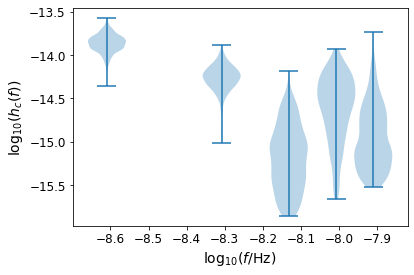

In [14]:
log10_h_samples = 0.5*np.log10(12*np.pi**2) + \
                    0.5*log10_S_samples + \
                        1.5*np.log10(NANOGrav_frequencies[:Nfreqs])

plt.violinplot(log10_h_samples, 
               positions=np.log10(NANOGrav_frequencies[:Nfreqs]),
               widths=0.1)
plt.xlabel(r'$\log_{10}$($f$/Hz)'); plt.ylabel(r'$\log_{10}$($h_c(f)$)')
plt.show()


### The energy density, $\hat{\Omega}_{\rm GW}(f)$

We can also convert to the energy density, $\hat{\Omega}_{\rm GW}(f)$,

$$ \hat{\Omega}_{\rm GW}(f) = \frac{2\pi^2}{3 H_0^2} f^2 h^2_c(f) . $$

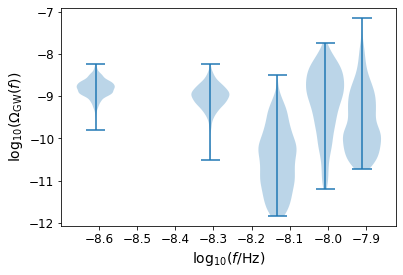

In [17]:
log10_Om_samples = 2*log10_h_samples + \
                    2*np.log10(NANOGrav_frequencies[:Nfreqs]) + \
                        np.log10(2 * np.pi**2 / 3) - \
                            2*np.log10(H_0_IN_ONE_OVER_SEC)
    
plt.violinplot(log10_Om_samples, 
               positions=np.log10(NANOGrav_frequencies[:Nfreqs]),
               widths=0.1)
plt.xlabel(r'$\log_{10}$($f$/Hz)'); plt.ylabel(r'$\log_{10}$($\Omega_{\rm GW}(f)$)')
plt.show()


### Building the KDEs 

We now make KDEs of the posterior samples. We will use these KDEs to make our log-likelihood function.

We choose to build our KDE using the samples of $\log_{10}\Omega_{\rm GW}(f)$ at the first 5 frequency bins, but you could equaly well use $h_c(f)$ or $S(f)$.

In [18]:
KDE = {i: kde(log10_Om_samples[:,i]) for i in range(Nfreqs)}

# Analysing the PT model

We use the spectrum model that is nicely visualised here, https://mybinder.org/v2/gh/AMitridate/bokeh/master?urlpath=/proxy/5006/bokeh-app and codes available at https://github.com/AMitridate/bokeh/tree/master/bokeh-app. This is also what was used in https://arxiv.org/pdf/2104.13930.pdf.

In [19]:
def spectrum(x, freqs=None):
    log10_H_star_over_beta = x[0]
    log10_T_star = x[1]
    log10_alpha_star = x[2]
    log10_eta = x[3]
    
    if freqs is None:
        freqs = NANOGrav_frequencies[0:5]
    
    return np.nan_to_num(h2_omega_sum(freqs, 
                    log10_T_star, 
                    log10_H_star_over_beta, 
                    log10_alpha_star, 
                    log10_eta))

om_min = 1.0e-18

def log_likelihood(x):
    omegagw = spectrum(x)
    omegagw = np.maximum(om_min, omegagw)

    log10_omegagw = np.log10(omegagw)
        
    logL = 0
    for i in range(Nfreqs):
        logL += KDE[i].logpdf(log10_omegagw[i])[0]
    
    return logL

# log10_H_star_over_beta, log10_T_star, log10_alpha_star, log10_eta
ranges = [[-2., 0.], [-4., 3.], [-2., 1.], [-2., 1.]]

priors = [uniform(loc=r[0], scale=r[1]-r[0]) for r in ranges]

def prior_transform(u):
    x = np.array(u)
    
    for i in range(len(x)):
        x[i] = priors[i].ppf(u[i])
        
    return x

ndim = len(priors)
nlive = 4096
sampler = NestedSampler(log_likelihood, prior_transform, ndim,
                        nlive=nlive, bound='multi', sample='slice')

sampler.run_nested()
results = sampler.results

Nsamples = len(results.samples)
print("{} samples produced".format(Nsamples))


16496it [06:51, 40.14it/s, +4096 | bound: 4 | nc: 1 | ncall: 305002 | eff(%):  6.751 | loglstar:   -inf < -2.371 <    inf | logz: -7.809 +/-  0.076 | dlogz:  0.001 >  4.105] 


20592 samples produced


In [20]:
from weighted_quantiles import quantile

MAPindex = np.argmax(results.logl)

# use a subset of posterior samples, for speed during testing
#subsamples_ind = np.random.choice(np.arange(Nsamples), 1000 replace=False)

# use all samples
subsamples_ind = np.arange(Nsamples)


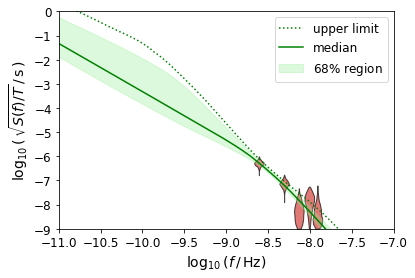

In [22]:
fig, ax = plt.subplots()

parts = ax.violinplot([log10_delay_samples[:, i] for i in range(Nfreqs)],
              showmeans=False,
              showmedians=False,
              showextrema=False,
              widths = 0.115,
              points=10,
              positions=np.log10(NANOGrav_frequencies[0:5]))

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

logfreq_grid = np.linspace(-11.5, -6.5, 300)
d = np.zeros((len(logfreq_grid), len(subsamples_ind)))
for i in range(len(subsamples_ind)):
    freqs = 10**logfreq_grid
    omegagw = spectrum(results.samples[subsamples_ind[i]], freqs=freqs)
    omegagw = np.maximum(om_min, omegagw)
    hc = np.sqrt((3*H_0_IN_ONE_OVER_SEC**2*omegagw)/(2*np.pi**2*freqs**2))
    S = hc**2 * freqs**-3 / (12*np.pi**2)
    delay = np.sqrt(S*NANOGrav_frequencies[0])
    d[:,i] = np.log10(delay)
    
low = quantile(d, np.exp(results.logwt), 0.16)
mid = quantile(d, np.exp(results.logwt), 0.5)
up = quantile(d, np.exp(results.logwt), 0.84)
UP = quantile(d, np.exp(results.logwt), 0.95)

plt.plot(logfreq_grid, UP, label='upper limit', color='green', ls=':')
plt.plot(logfreq_grid, mid, label='median', color='green')
plt.fill_between(logfreq_grid, low, y2=up, color='lightgreen', alpha=0.3, label=r'$68\%$ region')

ax.set_xlabel("$\log_{10}\, ( f\,/\,\mathrm{Hz} )$")
ax.set_ylabel("$\log_{10}\, ( \,\sqrt{S(f)/T} \,/\, \mathrm{s} \,)$")

ax.set_xlim(-11., -7.)
ax.set_ylim(-9., 0.)

plt.legend()

plt.show()
    

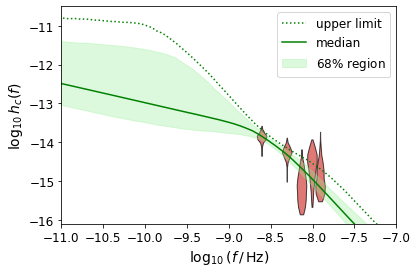

In [23]:
fig, ax = plt.subplots()

parts = ax.violinplot([log10_h_samples[:, i] for i in range(Nfreqs)],
              showmeans=False,
              showmedians=False,
              showextrema=False,
              widths = 0.115,
              points=10,
              positions=np.log10(NANOGrav_frequencies[0:5]))

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

logfreq_grid = np.linspace(-11.5, -6.5, 300)
d = np.zeros((len(logfreq_grid), len(subsamples_ind)))
for i in range(len(subsamples_ind)):
    freqs = 10**logfreq_grid
    omegagw = spectrum(results.samples[subsamples_ind[i]], freqs=freqs)
    omegagw = np.maximum(om_min, omegagw)
    hc = np.sqrt((3*H_0_IN_ONE_OVER_SEC**2*omegagw)/(2*np.pi**2*freqs**2))
    d[:,i] = np.log10(hc)
    
low = quantile(d, np.exp(results.logwt), 0.16)
mid = quantile(d, np.exp(results.logwt), 0.5)
up = quantile(d, np.exp(results.logwt), 0.84)
UP = quantile(d, np.exp(results.logwt), 0.95)

plt.plot(logfreq_grid, UP, label='upper limit', color='green', ls=':')
plt.plot(logfreq_grid, mid, label='median', color='green')
plt.fill_between(logfreq_grid, low, y2=up, color='lightgreen', alpha=0.3, label=r'$68\%$ region')

ax.set_xlabel("$\log_{10}\, ( f\,/\,\mathrm{Hz} )$")
ax.set_ylabel("$\log_{10}\, h_{c}(f)$")

ax.set_xlim(-11., -7.)
ax.set_ylim(-16.1, -10.5)

plt.legend()

plt.show()
    

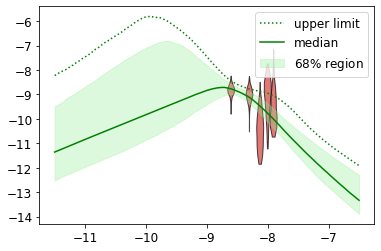

In [24]:
fig, ax = plt.subplots()

parts = ax.violinplot([log10_Om_samples[:, i] for i in range(Nfreqs)],
              showmeans=False,
              showmedians=False,
              showextrema=False,
              widths = 0.115,
              points=10,
              positions=np.log10(NANOGrav_frequencies[0:5]))

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

logfreq_grid = np.linspace(-11.5, -6.5, 300)
d = np.zeros((len(logfreq_grid), len(subsamples_ind)))
for i in range(len(subsamples_ind)):
    freqs = 10**logfreq_grid
    omegagw = spectrum(results.samples[subsamples_ind[i]], freqs=freqs)
    d[:,i] = np.log10(np.maximum(om_min, omegagw))
    
low = quantile(d, np.exp(results.logwt), 0.16)
mid = quantile(d, np.exp(results.logwt), 0.5)
up = quantile(d, np.exp(results.logwt), 0.84)
UP = quantile(d, np.exp(results.logwt), 0.95)

plt.plot(logfreq_grid, UP, label='upper limit', color='green', ls=':')
plt.plot(logfreq_grid, mid, label='median', color='green')
plt.fill_between(logfreq_grid, low, y2=up, color='lightgreen', alpha=0.3, label=r'$68\%$ region')

plt.legend()

plt.show()
    

### Other integrated constraints on the background

These might come from, for example, BBN, CMB or astrometry.

In [26]:
log10_Hubble_f, log10_3year_f = np.log10(H_0_IN_ONE_OVER_SEC), np.log10(1/(3*year))

def log_likelihood_other(x):
    omegagw = spectrum(x)
    omegagw = np.maximum(om_min, omegagw)

    log10_omegagw = np.log10(omegagw)
        
    logL = 0
    for i in range(Nfreqs):
        logL += KDE[i].logpdf(log10_omegagw[i])[0]

    Om = 1.0e-6
    logfreq_grid = np.linspace(log10_Hubble_f, log10_3year_f, 1000)
    freqs = 10.0**logfreq_grid
    omegagw = spectrum(x, freqs=freqs)
    Omega = np.trapz(omegagw, x=np.log(freqs))

    if Omega<Om:
        return logL
    else:
        return -np.inf
    
other_sampler = NestedSampler(log_likelihood_other, prior_transform, ndim,
                        nlive=nlive, bound='multi', sample='slice')

other_sampler.run_nested()
other_results = other_sampler.results

print(len(other_results.samples))


17008it [10:39, 26.60it/s, +4096 | bound: 6 | nc: 1 | ncall: 340483 | eff(%):  6.198 | loglstar:   -inf < -2.386 <    inf | logz: -7.965 +/-    nan | dlogz:  0.001 >  4.105] 


21104


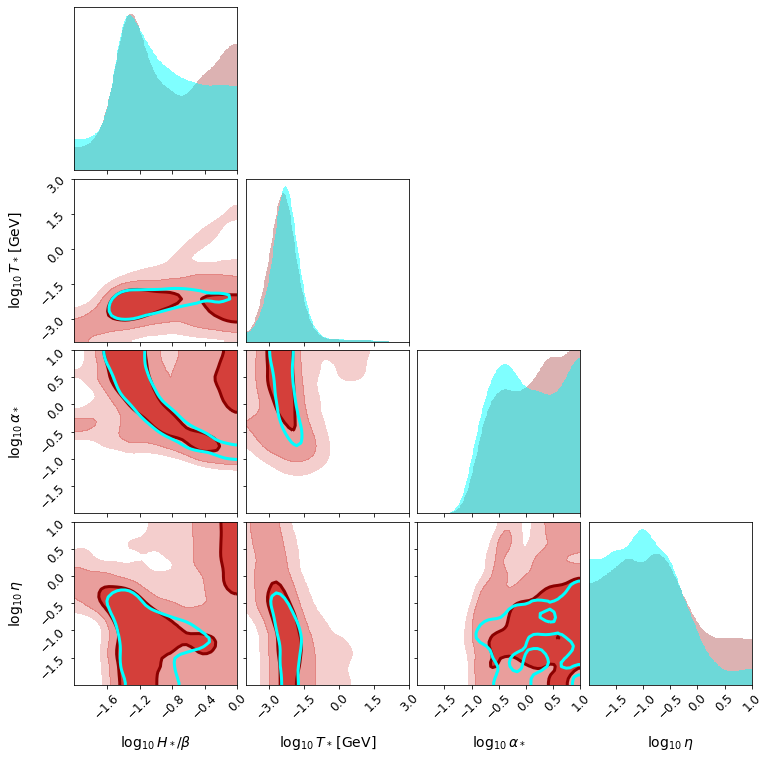

In [27]:
labels = [r"$\log_{10}\,H_*/\beta$", 
          r"$\log_{10}\,T_*\,[\mathrm{GeV}]$", 
          r"$\log_{10}\,\alpha_*$", 
          r"$\log_{10}\,\eta$"]

fig, axes = dyplot.cornerplot(results, 
                              quantiles=[],
                              quantiles_2d=[0.5, 0.9, 0.98],
                              color='#D43F3A', 
                              hist_kwargs={'alpha':0.},
                              hist2d_kwargs={'fill_contours':True,
                                             'plot_datapoints':False,
                                             'plot_density':True,
                                            'plot_contours':True,
                                            'contour_kwargs':{'alpha':0}},
                              span=ranges,
                              labels=labels,
                              max_n_ticks=6,
                              smooth=np.array([0.05, 0.05, 0.05, 0.05]),
                              fig=plt.subplots(ndim, ndim, figsize=(11, 11)))


fig, axes = dyplot.cornerplot(results, 
                              quantiles=[], 
                              quantiles_2d=[0.5],
                              color='darkred', 
                              hist_kwargs={'alpha':0.3},
                              hist2d_kwargs={'fill_contours':False,
                                             'plot_datapoints':False,
                                             'plot_density':False,
                                             'no_fill_contours':True,
                                            'contour_kwargs':{'linewidths':3}},
                              span=ranges,
                              labels=labels,
                              max_n_ticks=6,
                              smooth=np.array([0.05, 0.05, 0.05, 0.05]),
                              fig=(fig, axes))

fig, axes = dyplot.cornerplot(other_results, 
                              quantiles=[], 
                              quantiles_2d=[0.5],
                              color='cyan',
                              hist_kwargs={'alpha':0.5},
                              hist2d_kwargs={'fill_contours':False,
                                             'plot_datapoints':False,
                                             'plot_density':False,
                                             'no_fill_contours':True,
                                            'contour_kwargs':{'linewidths':3}},
                              span=ranges,
                              labels=labels,
                              max_n_ticks=6,
                              smooth=np.array([0.05, 0.05, 0.05, 0.05]),
                              fig=(fig, axes))

plt.show()
    

# Analysing the power-law model

$$ h_c(f) = A_{CP} (f/f_{\rm yr})^{\alpha_{CP}}, \quad \mathrm{for} \quad f_{\rm low}<f<f_{\rm high}.  $$

In [28]:
def spectrum_PL(x, freqs=None):
    """
    INPUTS
    ------
    x: array
        a vector of the model parameters. These include:
            - log_10_amplitude
            - spectral slope index, gamma
    freqs: array
        the frequencies [Hz] at which to evaluate the model
    """
    A_CP = 10.0**x[0]
    gamma = x[1]
    
    alpha = (3-gamma)/2
    
    if freqs is None:
        freqs = NANOGrav_frequencies[0:Nfreqs]
    
    # the power-law model for the characterisic strain
    hc = A_CP * (freqs * year)**alpha
    
    # convert hc to Omega, so we can compare with out KDEs
    omegagw = (2*np.pi**2) * freqs**2 * hc**2 / (3*H_0_IN_ONE_OVER_SEC**2)
    
    return omegagw

def log_likelihood_PL(x):
    log10_omega_gw = np.log10(spectrum_PL(x))
        
    logL = 0.
    for i in range(Nfreqs):
        logL += KDE[i].logpdf(log10_omega_gw[i])[0]

    return logL

ranges_PL = [[-17., -12.], [0., 7.]]
priors_PL = [uniform(loc=r[0], scale=r[1]-r[0]) for r in ranges_PL]

def prior_transform_PL(u):
    x = np.array(u)
    for i in range(len(x)):
        x[i] = priors_PL[i].ppf(u[i])  
    return x

ndim_PL = len(priors_PL)
PL_sampler = NestedSampler(log_likelihood_PL, prior_transform_PL, ndim_PL,
                        nlive=nlive, bound='multi', sample='slice')

PL_sampler.run_nested()
PL_results = PL_sampler.results

print(len(PL_results.samples))


15349it [02:21, 108.77it/s, +4096 | bound: 1 | nc: 1 | ncall: 170648 | eff(%): 11.395 | loglstar:   -inf < -2.647 <    inf | logz: -7.262 +/-  0.011 | dlogz:  0.001 >  4.105]


19445


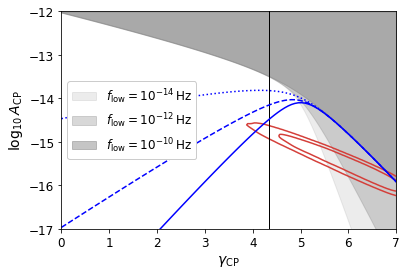

In [29]:
log10_BBN_f = -10.

fig, ax = plt.subplots()

sns.kdeplot(x=PL_results.samples[:,1], y=PL_results.samples[:,0],
            weights=np.exp(PL_results.logwt),
            levels=[0.01, 0.1],
            color='#D43F3A',
            ax=ax)

ax.set_xlim(ranges_PL[1])
ax.set_ylim(ranges_PL[0])

ax.set_xlabel(r"$\gamma_\mathrm{CP}$")
ax.set_ylabel("$\log_{10}\, A_\mathrm{CP}$")

ax.axvline(13/3, color='k', lw=1)



### Astrometry
labels = [r"$f_{\rm low}=10^{-14}\,\mathrm{Hz}$", 
          r"$f_{\rm low}=10^{-12}\,\mathrm{Hz}$", 
          r"$f_{\rm low}=10^{-10}\,\mathrm{Hz}$"]

Om_lim = 1.0e-6
for j, log10_f_low in enumerate([-14,-12,-10]):
    Om = Om_lim
    logfreq_grid = np.linspace(log10_f_low, log10_3year_f, 1000)
    freqs = 10.0**logfreq_grid

    gamma_grid = np.linspace(0, 7, 100)
    A_CP_Astro_Lim = np.zeros(len(gamma_grid))
    for i, gamma_CP in enumerate(gamma_grid):
        x = np.array([0., gamma_CP])
        omegagw = spectrum_PL(x, freqs=freqs)
        Omega = np.trapz(omegagw, x=np.log(freqs))
        A_CP_Astro_Lim[i] = np.sqrt(Om_lim/Omega)

    ax.fill_between(gamma_grid, np.log10(A_CP_Astro_Lim), 
                                y2=-12*np.ones_like(A_CP_Astro_Lim),
                                alpha=0.15*(j+1),
                                color='gray', label=labels[j])
    
###


### BBN
linestyles = [':', '--', '-']

Om_lim = 1.0e-6
for j, log10_f_high in enumerate([-7,-6,-5]):
    Om= Om_lim
    logfreq_grid = np.linspace(log10_BBN_f, log10_f_high, 1000)
    freqs = 10.0**logfreq_grid

    gamma_grid = np.linspace(0, 7, 100)
    A_CP_BBN_Lim = np.zeros(len(gamma_grid))
    for i, gamma_CP in enumerate(gamma_grid):
        x = np.array([0., gamma_CP])
        omegagw = spectrum_PL(x, freqs=freqs)
        Omega = np.trapz(omegagw, x=np.log(freqs))
        A_CP_BBN_Lim[i] = np.sqrt(Om_lim/Omega)

    ax.plot(gamma_grid, np.log10(A_CP_BBN_Lim), 
                                linestyle=linestyles[j],
                                color='blue')#, label=labels[j])
    
###


plt.legend(loc='center left', frameon=True, framealpha=1)

plt.show()
    

# Analysing the astrophysical BBH model

In [31]:
from scipy.special import gamma
from scipy.integrate import quad
from mpmath import gammainc 

# cosmological parameters: Omega_matter, Omega_curvature and Omega_Lambda
Omm, Omk, OmL = cosmo.Om0, cosmo.Ok0, cosmo.Ode0

# some units for the BH masses
G = 6.67e-11
c = 3.0e8
Msun = 2.0e30
const = (4/3) * (G*Msun)**(5/3) / np.pi**(1/3) / c**2

# volume units
pc = 3.086e+16
perMpc3_perGyr = (1.0e6*pc)**(-3) * (1.0e9*year)**(-1)

# limits of integration for mass and z
z_low, z_high = 0., 5.
Mc_low, Mc_high = 1.0e6, 1.0e11 


def spectrum_BBH(x, freqs=None):
    """
    INPUTS
    ------
    x: array
        a vector of the model parameters. These include:
            - log10_ndot_0, alpha_M, log10_M_star, beta_z, z_0
    freqs: array
        the frequencies [Hz] at which to evaluate the model
    """
    ndot_0 = 10.0**x[0] * perMpc3_perGyr
    alpha_M = x[1]
    M_star = 10.0**x[2]
    beta_z = x[3]
    z_0 = x[4]
        
    if freqs is None:
        freqs = NANOGrav_frequencies[0:Nfreqs]
    
    # integral over Mc
    IntMc = (M_star)**(5/3) * (M_star/1.0e7)**(-alpha_M) / np.log(10.)
    IntMc *= float(gammainc(5/3-alpha_M, Mc_low/M_star)) - float(gammainc(5/3-alpha_M, Mc_high/M_star))
    
    # integral over z
    H0 = H_0_IN_ONE_OVER_SEC
    integrand = lambda z:(1+z)**(beta_z-1/3)*np.exp(-z/z_0) / (H0*(1+z)*np.sqrt(Omm*(1+z)**3+Omk*(1+z)**2+OmL))
    integral = quad(integrand, z_low, z_high)[0]

    # GW background: h_c
    hcsq = const * freqs**(-4/3) * ndot_0 * IntMc * integral
    
    # GW background: Omega_GW
    Om = hcsq * (2*np.pi**2*freqs**2) / (3*H_0_IN_ONE_OVER_SEC**2)
    
    return Om
    
def log_likelihood_BBH(x):
    omegagw = spectrum_BBH(x)
    omegagw = np.maximum(om_min, omegagw)
    
    log10_omega_gw = np.log10(omegagw)
        
    logL = 0.
    for i in range(Nfreqs):
        logL += KDE[i].logpdf(log10_omega_gw[i])[0]

    return logL

ranges_BBH = [[-20., 3.], [-3., 3.], [6., 10.], [-2., 7.], [0.2, 5.]]
priors_BBH = [uniform(loc=r[0], scale=r[1]-r[0]) for r in ranges_BBH]

def prior_transform_BBH(u):
    x = np.array(u)
    for i in range(len(x)):
        x[i] = priors_BBH[i].ppf(u[i])  
    return x

ndim_BBH = len(priors_BBH)
BBH_sampler = NestedSampler(log_likelihood_BBH, prior_transform_BBH, ndim_BBH,
                        nlive=nlive//2, bound='multi', sample='slice')

BBH_sampler.run_nested()
BBH_results = BBH_sampler.results

print(len(BBH_results.samples))


8313it [05:48, 23.88it/s, +2048 | bound: 6 | nc: 1 | ncall: 177106 | eff(%):  5.850 | loglstar:   -inf < -5.503 <    inf | logz: -9.653 +/-    nan | dlogz:  0.001 >  2.057]  

10361


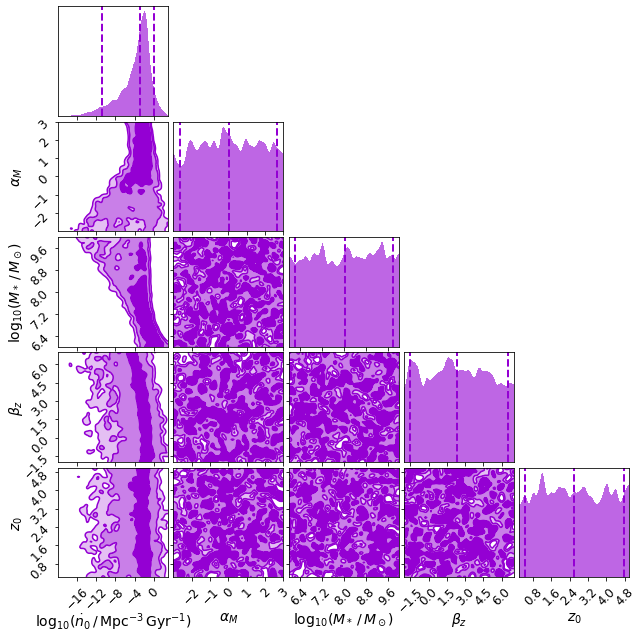

In [32]:
labels = [r"$\log_{10}(\dot{n}_0 \, / \,\mathrm{Mpc}^{-3}\,\mathrm{Gyr}^{-1})$", 
          r"$\alpha_M$", 
          r"$\log_{10}(M_* \,/\, M_\odot)$", 
          r"$\beta_z$",
          r"$z_0$"]

fig, axes = dyplot.cornerplot(BBH_results, 
                              quantiles=[0.05,0.5,0.95], 
                              quantiles_2d=[0.5, 0.9, 0.98],
                              color='darkviolet',
                              span=ranges_BBH,
                              labels=labels,
                              max_n_ticks=6,
                              fig=plt.subplots(ndim_BBH, ndim_BBH, figsize=(9, 9)))

plt.show()
    

# Analysing the PT+BBH model(s)

In [33]:
def log_likelihood_PT_BBH(x):
    # PT
    omegagw_PT = spectrum(x[:4])
    omegagw_PT = np.maximum(om_min, omegagw_PT)
    
    # BBH
    omegagw_BBH = spectrum_BBH(x[4:])
    omegagw_BBH = np.maximum(om_min, omegagw_BBH)
    
    log10_omega_gw = np.log10(omegagw_PT+omegagw_BBH)
        
    logL = 0.
    for i in range(Nfreqs):
        logL += KDE[i].logpdf(log10_omega_gw[i])[0]

    return logL

ranges_PT_BBH = ranges + ranges_BBH
priors_PT_BBH = [uniform(loc=r[0], scale=r[1]-r[0]) for r in ranges_PT_BBH]

def prior_transform_PT_BBH(u):
    x = np.array(u)
    for i in range(len(x)):
        x[i] = priors_PT_BBH[i].ppf(u[i])  
    return x

ndim_PT_BBH = len(priors_PT_BBH)
PT_BBH_sampler = NestedSampler(log_likelihood_PT_BBH, prior_transform_PT_BBH, ndim_PT_BBH,
                        nlive=nlive, bound='multi', sample='slice')

PT_BBH_sampler.run_nested()
PT_BBH_results = PT_BBH_sampler.results

print(len(PT_BBH_results.samples))


14796it [09:04, 27.18it/s, +4096 | bound: 1 | nc: 1 | ncall: 179057 | eff(%): 10.551 | loglstar:   -inf < -2.384 <    inf | logz: -7.807 +/-  0.112 | dlogz:  0.001 >  4.105] 


18892


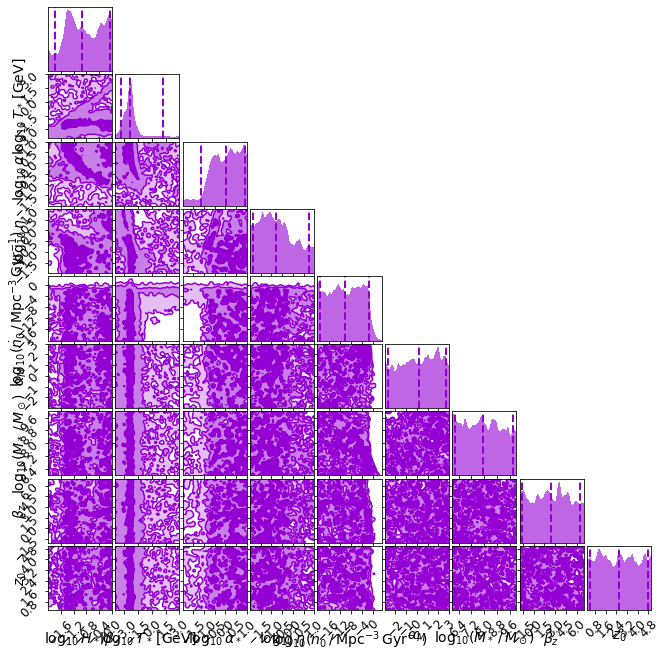

In [34]:
labels = [r"$\log_{10}\,H_*/\beta$", 
          r"$\log_{10}\,T_*\,[\mathrm{GeV}]$", 
          r"$\log_{10}\,\alpha_*$", 
          r"$\log_{10}\,\eta$",
          r"$\log_{10}(\dot{n}_0 \, / \,\mathrm{Mpc}^{-3}\,\mathrm{Gyr}^{-1})$", 
          r"$\alpha_M$", 
          r"$\log_{10}(M_* \,/\, M_\odot)$", 
          r"$\beta_z$",
          r"$z_0$"]

fig, axes = dyplot.cornerplot(PT_BBH_results, 
                              quantiles=[0.05,0.5,0.95], 
                              quantiles_2d=[0.5, 0.9, 0.98],
                              color='darkviolet',
                              span=ranges_PT_BBH,
                              labels=labels,
                              max_n_ticks=6,
                              fig=plt.subplots(ndim_PT_BBH, ndim_PT_BBH, figsize=(9, 9)))

plt.show()
    

In [35]:
def log_likelihood_PT_BBH_other(x):
    # PT
    omegagw_PT = spectrum(x[:4])
    omegagw_PT = np.maximum(om_min, omegagw_PT)
    
    # BBH
    omegagw_BBH = spectrum_BBH(x[4:])
    omegagw_BBH = np.maximum(om_min, omegagw_BBH)
    
    log10_omegagw = np.log10(omegagw_PT+omegagw_BBH)
        
    logL = 0
    for i in range(Nfreqs):
        logL += KDE[i].logpdf(log10_omegagw[i])[0]

    Om = 1.0e-6
    logfreq_grid = np.linspace(log10_Hubble_f, log10_3year_f, 1000)
    freqs = 10.0**logfreq_grid
    omegagw = spectrum(x[:4], freqs=freqs) + spectrum_BBH(x[4:], freqs=freqs)
    Omega = np.trapz(omegagw, x=np.log(freqs))

    if Omega<Om:
        return logL
    else:
        return -np.inf
    
other_PT_BBH_sampler = NestedSampler(log_likelihood_PT_BBH_other, prior_transform_PT_BBH, ndim_PT_BBH,
                        nlive=nlive, bound='multi', sample='slice')

other_PT_BBH_sampler.run_nested()
other_PT_BBH_results = other_PT_BBH_sampler.results

print(len(other_PT_BBH_results.samples))


14908it [19:10, 12.95it/s, +4096 | bound: 2 | nc: 1 | ncall: 268288 | eff(%):  7.083 | loglstar:   -inf < -2.390 <    inf | logz: -7.874 +/-    nan | dlogz:  0.002 >  4.105] 


19004


### plotting

In [36]:
f_min_PTA, f_max_PTA = 1/(12.5*year), 1/(2.5*year)

logfreq_grid = np.linspace(np.log10(f_min_PTA), np.log10(f_max_PTA), 1000)
freq_grid = 10.0**logfreq_grid


In [37]:
log10Om_PT = []

new_samples = resample_equal(results.samples, np.exp(results.logwt-max(results.logwt)))

for i, sample in enumerate(new_samples):
    
    omegagw = spectrum(sample, freqs=freq_grid)
    X = np.log10(np.trapz(omegagw, x=np.log(freq_grid)))
    
    if X>np.log10(om_min):
        log10Om_PT.append( X )


/usr/local/lib/python3.9/site-packages/dynesty/utils.py:163: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


In [38]:
log10Om_BBH = []

new_BBH_samples = resample_equal(BBH_results.samples, np.exp(BBH_results.logwt-max(BBH_results.logwt)))

for i, sample in enumerate(new_BBH_samples):
    
    omegagw = spectrum_BBH(sample, freqs=freq_grid)
    X = np.log10(np.trapz(omegagw, x=np.log(freq_grid)))
    
    if X>np.log10(om_min):
        log10Om_BBH.append( X )
        

In [39]:
log10Om_BBH_PT = []

new_PT_BBH_samples = resample_equal(PT_BBH_results.samples, 
                                    np.exp(PT_BBH_results.logwt-max(PT_BBH_results.logwt)))

for i, sample in enumerate(new_PT_BBH_samples):
    
    omegagw = spectrum_BBH(sample[4:], freqs=freq_grid)
    X = np.log10(np.trapz(omegagw, x=np.log(freq_grid)))
    
    omegagw = spectrum(sample[:4], freqs=freq_grid)
    Y = np.log10(np.trapz(omegagw, x=np.log(freq_grid)))
    
    if X>np.log10(om_min) and Y>np.log10(om_min):
        log10Om_BBH_PT.append( [X, Y] )
    

In [40]:
log10Om_BBH_PT_other = []

new_other_PT_BBH_results = resample_equal(other_PT_BBH_results.samples, 
                                          np.exp(other_PT_BBH_results.logwt-max(other_PT_BBH_results.logwt)))

for i, sample in enumerate(new_other_PT_BBH_results):
    
    omegagw = spectrum_BBH(sample[4:], freqs=freq_grid)
    X = np.log10(np.trapz(omegagw, x=np.log(freq_grid)))
    
    omegagw = spectrum(sample[:4], freqs=freq_grid)
    Y = np.log10(np.trapz(omegagw, x=np.log(freq_grid)))
    
    if X>np.log10(om_min) and Y>np.log10(om_min):
        log10Om_BBH_PT_other.append( [X, Y] )
    

In [41]:
import pandas as pd

NS = min(len(log10Om_BBH), len(log10Om_PT))
data_marg = {
        'x_marg': np.random.choice(np.array(log10Om_BBH), NS, replace=False),
        'y_marg': np.random.choice(np.array(log10Om_PT), NS, replace=False)
        }
data_frame_marg = pd.DataFrame(data=data_marg)
         
data_red = {
        'X': np.array(log10Om_BBH_PT)[:,0],
        'Y': np.array(log10Om_BBH_PT)[:,1]
        }
data_frame_red = pd.DataFrame(data=data_red)

data_blue = {
        'X2': np.array(log10Om_BBH_PT_other)[:,0],
        'Y2': np.array(log10Om_BBH_PT_other)[:,1]
        }
data_frame_blue = pd.DataFrame(data=data_blue)


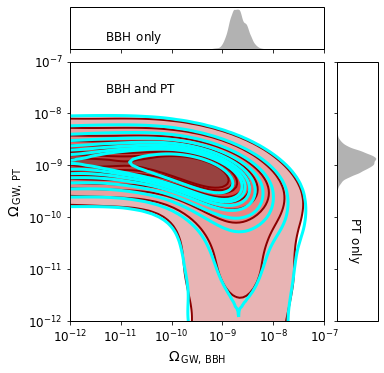

In [42]:
g = sns.JointGrid(space=.3, height=5)

bw_adjust = 1.
sns.kdeplot(data=data_frame_red, 
            x="X", y="Y",
            ax=g.ax_joint,
            color='#D43F3A',
            fill=True,
            bw_adjust=bw_adjust)
sns.kdeplot(data=data_frame_red, 
            x="X", y="Y",
            ax=g.ax_joint,
            color='darkred',
            fill=False,
            linewidths=2,
            bw_adjust=bw_adjust)
sns.kdeplot(data=data_frame_blue, 
            x="X2", y="Y2",
            ax=g.ax_joint,
            color='cyan',
            fill=False,
            linewidths=3,
            bw_adjust=bw_adjust)

sns.kdeplot(data=data_frame_marg, 
              x="x_marg",
              ax=g.ax_marg_x,
              fill=True, alpha=0.3, linewidth=0, color='k')

sns.kdeplot(data=data_frame_marg, 
              y="y_marg",
              ax=g.ax_marg_y,
              fill=True, alpha=0.3, linewidth=0, color='k')

g.ax_joint.set_xlabel(r'$\Omega_{\,\mathrm{GW,}\,\mathrm{BBH}}$')
g.ax_joint.set_ylabel(r'$\Omega_{\,\mathrm{GW,}\,\mathrm{PT}}$')

ticks = np.arange(-12, -6)
g.ax_joint.set_xticks(ticks)
g.ax_joint.set_xticklabels(['$10^{'+str(i)+'}$' for i in ticks])
g.ax_joint.set_yticks(ticks)
g.ax_joint.set_yticklabels(['$10^{'+str(i)+'}$' for i in ticks])

g.ax_joint.set_xlim(-12, -7.)
g.ax_joint.set_ylim(-12, -7.)

g.ax_joint.patch.set_edgecolor('black')  
g.ax_joint.patch.set_linewidth('1') 
g.ax_marg_x.patch.set_edgecolor('black')  
g.ax_marg_x.patch.set_linewidth('1') 
g.ax_marg_y.patch.set_edgecolor('black')  
g.ax_marg_y.patch.set_linewidth('1') 

font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': SMALL_SIZE,
        }
g.ax_joint.text(-11.3, -7.6, r'$\mathrm{BBH}\;\mathrm{and}\;\mathrm{PT}$', fontdict=font)
g.ax_marg_x.text(-11.3, 0.5, r'$\mathrm{BBH}\;\,\mathrm{only}$', fontdict=font)
g.ax_marg_y.text(0.5, -10.8, r'$\mathrm{PT}\;\,\mathrm{only}$', fontdict=font, rotation=-90)

plt.show()
    